In [3]:
import pandas as pd
import re
import nltk
import string
import pymorphy2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.regularizers import l2

In [4]:
df = pd.read_csv('data/labeled.csv')
(df.head(10))


,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [5]:
data = df['comment']
data.tail(30)

14382    90 не будет этим заниматься. Хохлов отрезают о...
14383                        Что. ты. несёшь. дегенерат?\n
14384    По идее это позор но поцреоты будут надрывно г...
14385                            КРАСНИЙ ЦЕ КОММУНИЗМ!!!\n
14386    Чем то она Мэгги Джилленхол напоминает. И да, ...
14387    джапы эту песню сто лет как поют, в чем новост...
14388      ПРОКЛЯТАЯ ДЕТОЕДСКАЯ МРАЗЬ. ГОРИ В АДУ ВЕЧНО.\n
14389    Как-будто, одно исключает другое. А ненавидеть...
14390    Принимал участие в этом опросе сказал что не д...
14391    Разве могут вертухай или ссаколовы собрать сто...
14392    ТАСС, 21 марта. Премьер-министр Новой Зеландии...
14393    вой подсоса гомофорсера Что, говно, неприятно ...
14394                             Шлюха. Это парад шлюх.\n
14395                      дебил-куколд Значение знаешь?\n
14396    Я хуею как сосачеры, где большиство прыщавые ж...
14397    Что-то появившееся на небе пугает туристов Кто...
14398    Моча в анимаче решила окончательно убить реакш.

In [6]:
comments = [text for text in data]
len(comments)

14412

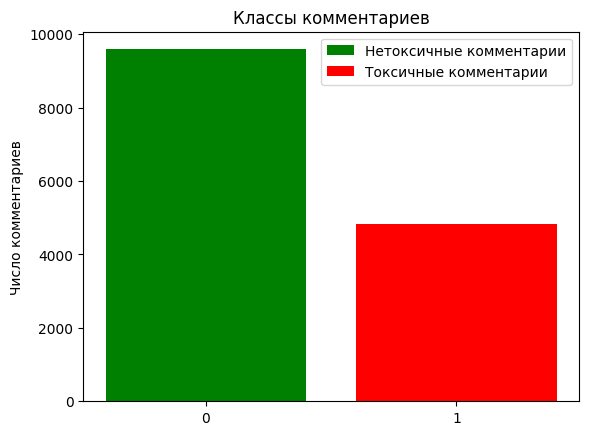

Comment description

      comment                                                               
        count unique                                                top freq
toxic                                                                       
0.0      9586   9586  В шапке были ссылки на инфу по текущему фильму...    1
1.0      4826   4826               Верблюдов-то за что? Дебилы, бл...\n    1

              toxic
count  14412.000000
mean       0.334860
std        0.471958
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [7]:
desc = df.groupby('toxic').describe()

plt.bar('0', desc['comment']['count'][0], label="Нетоксичные комментарии", color='green')
plt.bar('1', desc['comment']['count'][1], label="Токсичные комментарии", color='red')
plt.legend()
plt.ylabel('Число комментариев')
plt.title('Классы комментариев')
plt.show()

print('Comment description\n')
print(desc)
print()
print(df.describe())

In [8]:
morph = pymorphy2.MorphAnalyzer()
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower() #Нижний регистр + удаление пунктуационных знаков
    txt = re.sub(r'\d+', '', txt)


    lemmatized_text = []
    for word in txt.split():
        parsed_word = morph.parse(word)[0]
        lemmatized_word = parsed_word.normal_form
        lemmatized_text.append(lemmatized_word)

    txt = " ".join(lemmatized_text)
    
    txt = "".join(re.sub(r"\b\w\b", "", txt))
    
    return txt 

comments = [clean_text(x) for x in comments]


In [9]:
comments[:10]

['верблюдовто за что дебил бл',
 'хохол это отдушина затюканый россиянин мол вон   хохлов ещё плохой если бы хохлов не быть кисель они бы придумать',
 'собака собачий смерть',
 'страница обновить дебил это тоже не оскорбление  доказать факт недебил про себя  множественный число писать не быть или мы  ты верить это ты  твой воображать друг',
 'ты не убедить страничный пдф  тот что скрипаль отравить россия анализировать  думать пытаться ватник что ли',
 'для какой стан являться эталон современный система здравоохранение рф для зимбабве ты тупой хохол',
 ' шапка быть ссылка на инф по текущий фильм марвести этот ссылка быть заменить на фраза репортить брипидор игнорировать он пост если это недостаточно чтобы понять что модератор абсолютный неадекват  он нужно лишить полномочие тогда этот борд пробивать абсолютный дно по неадекватность',
 'упад так там нельзя строить технология нет разворовать как всегда уже трещина пош  тупой китаз не мочь ничего нормально сделать',
 'ебать ты разносить ши

In [11]:
labels = df['toxic'].values

In [12]:
print(labels)

[1. 1. 1. ... 0. 1. 0.]


In [13]:

tokenizer = Tokenizer()

def get_sequence_of_tokens(comments):
    ## tokenization
    tokenizer.fit_on_texts(comments)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    sequences = []
    for comment in comments:
        token_list = tokenizer.texts_to_sequences([comment])[0]
        sequences.append(token_list)
    return sequences, total_words

sequences, total_words = get_sequence_of_tokens(comments)

In [14]:
total_words

35777

In [15]:
print(comments[14])
print()
print((sequences)[14])


мочь на ты ещё  модер за безмозглый позвать

[20, 2, 15, 32, 1599, 14, 4842, 3730]


In [17]:
import keras.utils as ku
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences, df['toxic'].values
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(sequences)

In [18]:
print(predictors.shape)

(14412, 879)


In [19]:
print(labels[2])

1.0


In [20]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx+1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx+1) * self.batch_size]
        return batch_x, batch_y

In [21]:
def create_model():
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words,16, input_length=input_len))
    
    model.add(LSTM(16, kernel_regularizer=l2(0.005), 
                  bias_regularizer=l2(0.005)))
    
    
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 878, 16)           572432    
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 574,561
Trainable params: 574,561
Non-trainable params: 0
_________________________________________________________________


In [22]:
part = int(predictors.shape[0]*0.90)
part_tr_v = int(predictors.shape[0]*0.80)
part_v_te = int(predictors.shape[0]*0.90)
batch_size = 32
train_gen = DataGenerator(predictors[:part_tr_v], labels[:part_tr_v], batch_size)
val_gen = DataGenerator(predictors[part_tr_v:part_v_te], labels[part_tr_v:part_v_te], batch_size)
test_gen = DataGenerator(predictors[part_v_te:], labels[part_v_te:], batch_size)
print(train_gen.__len__())
print(val_gen.__len__())
print(test_gen.__len__())

360
45
45


In [23]:
model.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [24]:
history = model.fit(train_gen, validation_data = val_gen, verbose = 1, epochs = 15)

Epoch 1/15
 13/360 [>.............................] - ETA: 36s - loss: 0.8901 - precision: 0.1471 - recall: 0.0400 - auc: 0.4173

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

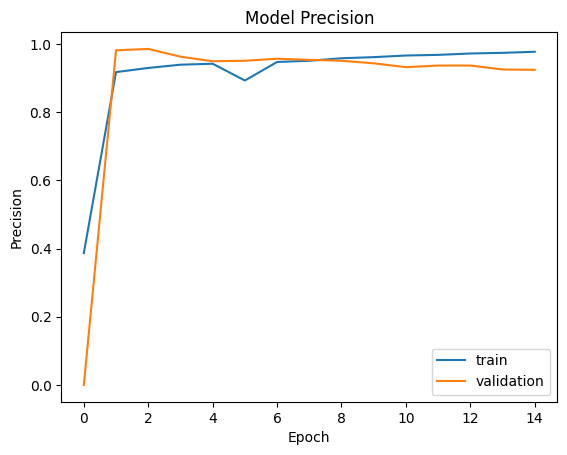

In [57]:
plt.plot(history.history['precision_10'], label='train')
plt.plot(history.history['val_precision_10'], label='validation')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()
plt.show()

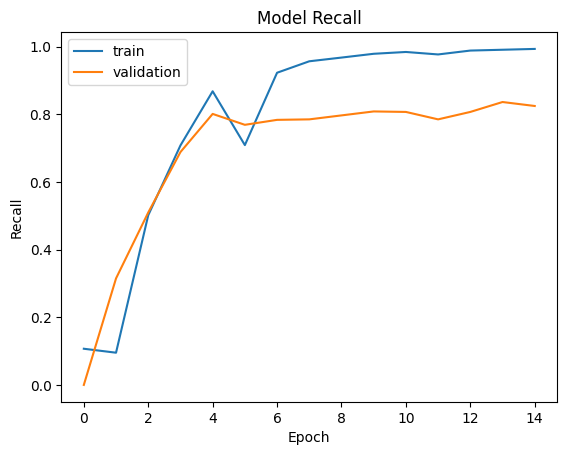

In [58]:
plt.plot(history.history['recall_10'], label='train')
plt.plot(history.history['val_recall_10'], label='validation')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()

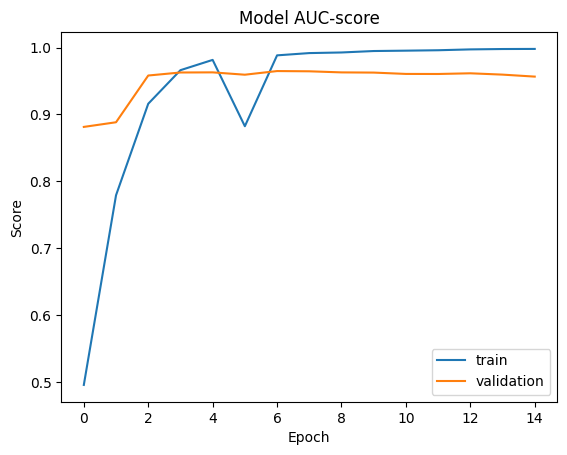

In [61]:
plt.plot(history.history['auc_6'], label='train')
plt.plot(history.history['val_auc_6'], label='validation')
plt.title('Model AUC-score')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [41]:
loss, precision, recall, auc = model.evaluate(test_gen)

1442/1442 [==============================] - 67s 46ms/step - loss: 0.4529 - precision_15: 0.9050 - recall_15: 0.7391 - auc_11: 0.9355


In [ ]:
model.save('toxic_detection.h5')

In [25]:
model = tf.keras.models.load_model('toxic_detection.h5')

In [26]:
import gradio as gr

In [ ]:
model = tf.keras.models.load_model('toxic_detection.h5')

In [128]:
model.save('toxic_detection.h5')

In [28]:
!pip freeze > requirments.txt

In [ ]:
def score_comment(comment):
    comment = clean_text(comment)
    array_comment = np.array([comment])
    sequence = tokenizer.texts_to_sequences(array_comment)
    pad_sequence = pad_sequences(sequence, maxlen = max_sequence_len - 1)
    prediction = model.predict(pad_sequence)

    
    text = f'Оценка = {round((prediction[0][0])*1, 2)}'
    
    return text

In [28]:
score_comment('Зайки я вас всех ценю, целую')

1/1 [==============================] - 0s 49ms/step


'Оценка = 0.22'

In [29]:
score_comment('вы все уроды редкостные')

1/1 [==============================] - 0s 50ms/step


'Оценка = 0.68'

In [19]:
interface = gr.Interface(fn = score_comment,
                        inputs = gr.components.Textbox(lines=2, placeholder='Напишите что-нибудь..'),
                        outputs = 'text')

In [20]:
interface.launch(share = True)

Running on local URL:  http://127.0.0.1:7860
1/1 [==============================] - 5s 5s/step

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app
